# Discretization

The aim of the notebook is to evaluate the performance of CategoricalHMM on discretized data

In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib
import itertools
from scipy.stats import multivariate_normal
from source.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES

In [2]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
# sns.set_context("talk")

# https://xkcd.com/color/rgb/

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
colors

[(0.6745098039215687, 0.7607843137254902, 0.8509803921568627),
 (0.33725490196078434, 0.6823529411764706, 0.3411764705882353),
 (0.6980392156862745, 0.6, 0.43137254901960786),
 (0.6588235294117647, 1.0, 0.01568627450980392),
 (0.4117647058823529, 0.8470588235294118, 0.30980392156862746),
 (0.5372549019607843, 0.27058823529411763, 0.5215686274509804),
 (0.4392156862745098, 0.6980392156862745, 0.24705882352941178),
 (0.8313725490196079, 1.0, 1.0),
 (0.396078431372549, 0.6705882352941176, 0.48627450980392156),
 (0.5843137254901961, 0.1803921568627451, 0.5607843137254902),
 (0.9882352941176471, 0.9882352941176471, 0.5058823529411764),
 (0.6470588235294118, 0.6392156862745098, 0.5686274509803921),
 (0.2196078431372549, 0.5019607843137255, 0.01568627450980392),
 (0.2980392156862745, 0.5647058823529412, 0.5215686274509804),
 (0.3686274509803922, 0.6078431372549019, 0.5411764705882353),
 (0.9372549019607843, 0.7058823529411765, 0.20784313725490197),
 (0.8509803921568627, 0.6078431372549019, 0.5098039215686274),
 (0.0392156862745098, 0.37254901960784315, 0.2196078431372549),
 (0.047058823529411764, 0.023529411764705882, 0.9686274509803922),
 (0.3803921568627451, 0.8705882352941177, 0.16470588235294117),
 (0.21568627450980393, 0.47058823529411764, 0.7490196078431373),
 (0.13333333333333333, 0.25882352941176473, 0.7803921568627451),
 (0.3254901960784314, 0.23529411764705882, 0.7764705882352941),
 (0.6078431372549019, 0.7098039215686275, 0.23529411764705882),
 (0.0196078431372549, 1.0, 0.6509803921568628),
 (0.12156862745098039, 0.38823529411764707, 0.3411764705882353),
 (0.00392156862745098, 0.45098039215686275, 0.4549019607843137),
 (0.047058823529411764, 0.7098039215686275, 0.4666666666666667),
 (1.0, 0.027450980392156862, 0.5372549019607843),
 (0.6862745098039216, 0.6588235294117647, 0.5450980392156862),
 (0.03137254901960784, 0.47058823529411764, 0.4980392156862745),
 (0.8666666666666667, 0.5215686274509804, 0.8431372549019608),
 (0.6509803921568628, 0.7843137254901961, 0.4588235294117647),
 (0.6549019607843137, 1.0, 0.7098039215686275),
 (0.7607843137254902, 0.7176470588235294, 0.03529411764705882),
 (0.9058823529411765, 0.5568627450980392, 0.6470588235294118),
 (0.5882352941176471, 0.43137254901960786, 0.7411764705882353),
 (0.8, 0.6784313725490196, 0.3764705882352941),
 (0.6745098039215687, 0.5254901960784314, 0.6588235294117647),
 (0.5803921568627451, 0.49411764705882355, 0.5803921568627451),
 (0.596078431372549, 0.24705882352941178, 0.6980392156862745),
 (1.0, 0.38823529411764707, 0.9137254901960784),
 (0.6980392156862745, 0.984313725490196, 0.6470588235294118),
 (0.38823529411764707, 0.7019607843137254, 0.396078431372549),
 (0.5568627450980392, 0.8980392156862745, 0.24705882352941178),
 (0.7176470588235294, 0.8823529411764706, 0.6313725490196078),
 (1.0, 0.43529411764705883, 0.3215686274509804),
 (0.7411764705882353, 0.9725490196078431, 0.6392156862745098),
 (0.8274509803921568, 0.7137254901960784, 0.5137254901960784),
 (1.0, 0.9882352941176471, 0.7686274509803922),
 (0.2627450980392157, 0.0196078431372549, 0.2549019607843137),
 (1.0, 0.6980392156862745, 0.8156862745098039),
 (0.6, 0.4588235294117647, 0.4392156862745098),
 (0.6784313725490196, 0.5647058823529412, 0.050980392156862744),
 (0.7686274509803922, 0.5568627450980392, 0.9921568627450981),
 (0.3137254901960784, 0.4823529411764706, 0.611764705882353),
 (0.49019607843137253, 0.44313725490196076, 0.011764705882352941),
 (1.0, 0.9921568627450981, 0.47058823529411764),
 (0.8549019607843137, 0.27450980392156865, 0.49019607843137253),
 (0.2549019607843137, 0.00784313725490196, 0.0),
 (0.788235294117647, 0.8196078431372549, 0.4745098039215686),
 (1.0, 0.9803921568627451, 0.5254901960784314),
 (0.33725490196078434, 0.5176470588235295, 0.6823529411764706),
 (0.4196078431372549, 0.48627450980392156, 0.5215686274509804),
 (0.43529411764705883, 0.4235294117647059, 0.0392156862745098),
 (0.49411764705882355, 0.25098039215686274, 0.44313725490196076),
 (0.0, 0.5764705882352941, 0.2156

In [4]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html

np.random.seed(42)

true_model3 = hmm.GaussianHMM(n_components=3, covariance_type="full")
true_model3.startprob_ = np.array([0.6, 0.3, 0.1])
true_model3.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model3.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model3.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

true_model3.sample(10)

(array([[ 0.9694375 , -0.83691634],
        [-0.72845739,  1.72027549],
        [ 0.13888981, -0.73856628],
        [-1.19070703, -0.62107079],
        [-1.39713416,  0.05274311],
        [-0.09710759, -1.41211893],
        [ 0.77049997, -0.29208482],
        [ 0.45061783, -0.42945405],
        [ 0.93529815, -0.11410115],
        [ 1.41712714,  0.27877223]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [5]:
true_model2 = hmm.GaussianHMM(n_components=2, covariance_type="full")
true_model2.startprob_ = true_model3.startprob_[:2] / true_model3.startprob_[:2].sum()
true_model2.transmat_ = true_model3.transmat_[:2, :2] / true_model3.transmat_[:2, :2].sum(axis=1).reshape(-1, 1)

true_model2.means_ = true_model3.means_[:2]
true_model2.covars_ = true_model3.covars_[:2]

true_model2.sample(10)

(array([[ 0.38101918, -0.47075945],
        [ 2.02364148, -2.5232011 ],
        [-1.36473817,  2.95830902],
        [-0.44026515,  0.72275594],
        [-0.11525016, -1.57529795],
        [ 0.89312562,  0.05620838],
        [ 0.88485255, -0.93366053],
        [ 3.63129627, -3.48988934],
        [ 0.05286998,  0.89759822],
        [ 0.43951158, -0.871224  ]]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0]))

In [6]:
norm1 = multivariate_normal(true_model3.means_[0], true_model3.covars_[0])
norm2 = multivariate_normal(true_model3.means_[1], true_model3.covars_[1])
norm3 = multivariate_normal(true_model3.means_[2], true_model3.covars_[2])

In [7]:
sample_sizes = [50, 100, 1000, 10000]
nodes_numbers = [3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100]

In [8]:
def eval_model(n_components, number_of_nodes, discretizing, X, Z):
    if discretizing is None:
        myHMM = hmm.GaussianHMM(n_components, n_iter=150)
    else:
        myHMM = DiscreteHMM(discretizing, number_of_nodes, n_components, n_iter=150)
    myHMM.fit(X)

    if discretizing is None:
        Z_hat = myHMM.predict(X)
        ll = myHMM.score(X)
    else:
        Xd = myHMM._discretize(X, False)
        Z_hat = myHMM.predict(Xd)
        ll = myHMM.score(Xd)

    if np.unique(Z_hat).shape[0] == n_components:
        Z_hat = find_permutation(Z, Z_hat)[Z_hat]
        acc = (Z_hat == Z).mean()
    else:
        print(f"Recognized {np.unique(Z_hat).shape[0]} instead of {n_components} states!")
        acc = -1
    return myHMM, ll, acc


def provide_grid(X):
    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm1.pdf(data).reshape(-1, 1), norm2.pdf(data).reshape(-1, 1), norm3.pdf(data).reshape(-1, 1)], axis=1)
    return XX, YY, lls


def plot_true_HMM(X, Z, n_components, XX, YY, lls):
    plt.figure(figsize=(5, 5))
    for k in range(n_components):
        plt.plot(X[Z==k, 0], X[Z==k, 1], 'o', mfc=colors[k], mec='none', ms=4, alpha=.5)
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.plot(X[:,0], X[:,1], '-k', lw=1, alpha=.1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    plt.show()

    return XX, YY, lls

def compare_models(models, X, XX, YY, lls, target_ll):
    fig, axs = plt.subplots(len(nodes_numbers), len(DISCRETIZATION_TECHNIQUES), sharex=True, sharey=True, figsize=(10, 10))
    summary = []
    for i, j in itertools.product(range(len(DISCRETIZATION_TECHNIQUES) + 1), range(len(nodes_numbers))):
        discretizing, number_of_nodes = [*DISCRETIZATION_TECHNIQUES, None][i], nodes_numbers[j]
        if number_of_nodes > sample_size:
            continue
        summary.append({
            'discretizing': discretizing, 'number_of_nodes': number_of_nodes,
            'accuracy': models[discretizing, number_of_nodes]['acc'],
            'log-likelihood': models[discretizing, number_of_nodes]['ll'],
            'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)
        })

        if discretizing is not None:
            myHMM = models[discretizing, number_of_nodes]['model']
            Xd = myHMM._discretize(X, False)
            for k in range(2):
                axs[j, i].contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=5, alpha=.4)
            for k in range(number_of_nodes):
                axs[j, i].plot(X[Xd[:, 0] == k, 0], X[Xd[:, 0] == k, 1], 'o', mec='none', ms=2, alpha=.5, mfc=colors[k % len(colors)])
            for k in range(number_of_nodes):
                axs[j, i].plot(myHMM.nodes[0, k], myHMM.nodes[1, k], '*', mec='none', ms=4, color='black', mfc=colors[k % len(colors)])

    for ax, col in zip(axs[0], DISCRETIZATION_TECHNIQUES):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], nodes_numbers):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()
    summary = pd.DataFrame(summary).sort_values('number_of_nodes')
    display(summary)
    print(summary.to_latex())
    sns.lineplot(data=summary, x='number_of_nodes', y='accuracy', hue='discretizing')
    plt.title("Accuracy")
    plt.show()
    sns.lineplot(data=summary, x='number_of_nodes', y='log-likelihood', hue='discretizing')
    plt.title("Log-likelihood")
    plt.show()


def evaluation(sample_size, n_components):
    true_model = true_model2 if n_components == 2 else true_model3
    X, Z = true_model.sample(sample_size)
    ll_target = true_model.score(X)

    XX, YY, lls = provide_grid(X)
    models = dict()
    for discretizing, number_of_nodes in itertools.product([*DISCRETIZATION_TECHNIQUES, None], nodes_numbers):
        if number_of_nodes > sample_size:
            continue
        myHMM, ll, acc = eval_model(n_components, number_of_nodes, discretizing, X, Z)
        models[discretizing, number_of_nodes] = {'ll': ll, 'acc': acc, 'model': myHMM}

    XX, YY, lls = provide_grid(X)
    plot_true_HMM(X, Z, n_components, XX, YY, lls)
    compare_models(models, X, XX, YY, lls, ll_target)

sample_size = 50


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

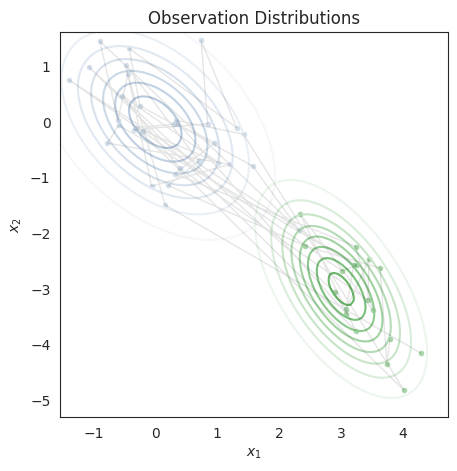

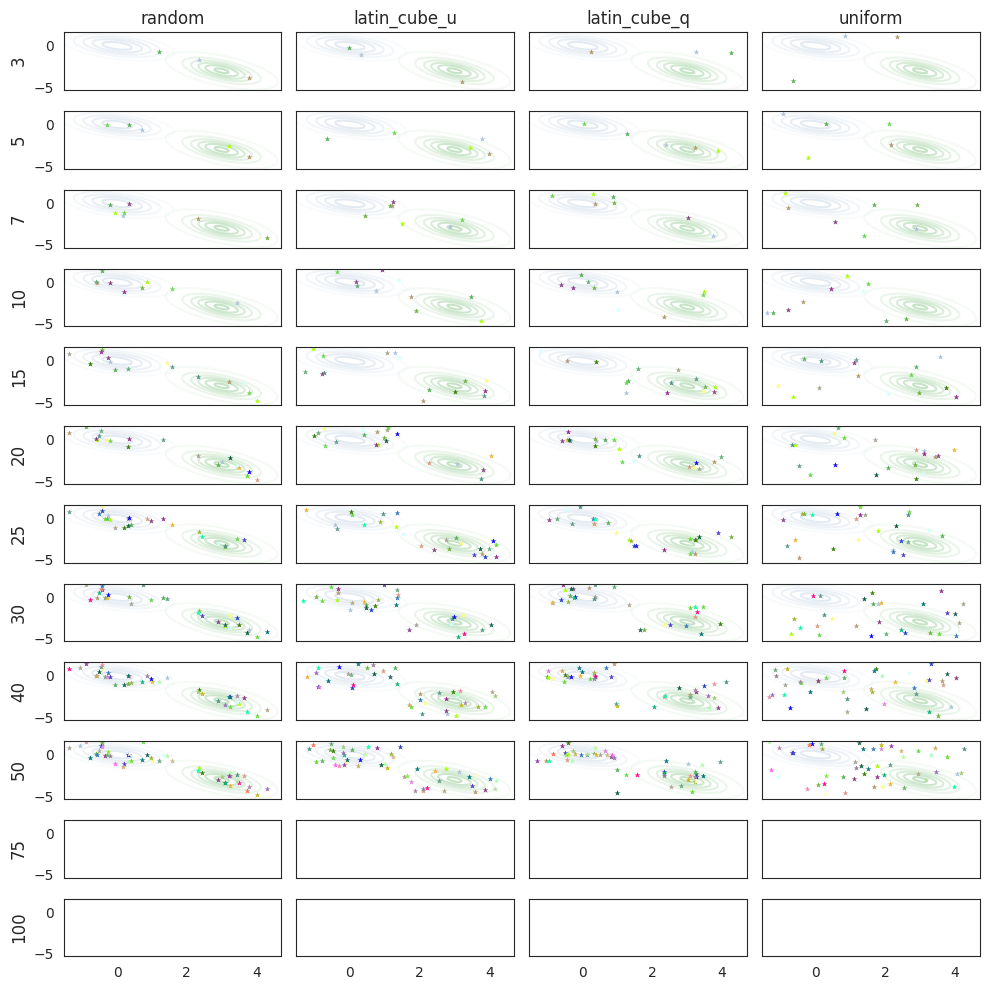

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.86       -8.258222      8.920251e+54
30       uniform                3      0.84       62.885397      7.041390e+85
20  latin_cube_q                3      0.98      201.078212     7.311989e+145
40          None                3      0.98     -138.261526      3.094994e-02
10  latin_cube_u                3      0.98       65.274618      7.678634e+86
21  latin_cube_q                5      0.98      -94.422245      3.387019e+17
41          None                5      0.98     -138.261526      3.094994e-02
11  latin_cube_u                5      0.96      -90.621597      1.515018e+19
1         random                5      0.98      -76.961320      1.297182e+25
31       uniform                5      0.98       19.032742      6.348809e+66
42          None                7      0.98     -138.261526      3.094994e-02
22  latin_cube_q                7      0.98     -114.413309      7.043827e+08
2         random                7      0.96     -107.705231      5.768860e+11
12  latin_cube_u                7      0.98      -64.468573      3.455667e+30
32       uniform                7      0.96      -18.878309      2.178372e+50
23  latin_cube_q               10      0.98     -131.015022      4.342866e+01
43          None               10      0.98     -138.261526      3.094993e-02
3         random               10      0.96       -1.685244      6.382418e+57
33       uniform               10      0.94       -1.056246      1.197170e+58
13  latin_cube_u               10      0.98     -145.867280      1.540007e-05
44          None               15      0.98     -138.261526      3.094993e-02
34       uniform               15      0.96      -97.242858      2.017627e+16
24  latin_cube_q               15      0.98     -130.125039      1.057527e+02
4         random               15      0.84     -156.666393      3.144325e-10
14  latin_cube_u               15      0.98     -140.545744      3.152366e-03
5         random               20      0.98     -133.011443      5.898504e+00
25  latin_cube_q               20      0.96     -107.888512      4.802774e+11
35       uniform               20      0.98     -121.012516      9.589798e+05
45          None               20      0.98     -138.261526      3.094994e-02
15  latin_cube_u               20      0.98     -127.802001      1.079378e+03
36       uniform               25      0.94     -136.538246      1.734086e-01
16  latin_cube_u               25      0.98     -133.671625      3.048094e+00
46          None               25      0.98     -138.261527      3.094990e-02
26  latin_cube_q               25      0.98      -85.714865      2.048258e+21
6         random               25      0.98     -121.687547      4.882555e+05
17  latin_cube_u               30      0.98     -129.830057      1.420366e+02
27  latin_cube_q               30      0.98     -122.289486      2.674415e+05
47          None               30      0.98     -138.261526      3.094992e-02
37       uniform               30      0.98     -131.475806      2.739432e+01
7         random               30      0.98     -135.173917      6.785649e-01
18  latin_cube_u               40      0.98     -132.343830      1.149959e+01
38       uniform               40      0.82     -159.319908      2.213710e-11
28  latin_cube_q               40      0.98     -114.437529      6.875279e+08
48          None               40      0.98     -138.261526      3.094994e-02
8         random               40      0.98     -136.460494      1.874295e-01
39       uniform               50      0.98     -146.458067      8.529967e-06
19  latin_cube_u               50      0.98     -135.340268      5.745741e-01
9         random               50      0.98     -138.261527      3.094991e-02
29  latin_cube_q               50      0.98     -113.799954      1.300725e+09
49          None               50      0.98     -138.261526      3.094994e-02

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.86 &       -8.258222 &      8.920251e+54 \\
30 &       uniform &                3 &      0.84 &       62.885397 &      7.041390e+85 \\
20 &  latin\_cube\_q &                3 &      0.98 &      201.078212 &     7.311989e+145 \\
40 &          None &                3 &      0.98 &     -138.261526 &      3.094994e-02 \\
10 &  latin\_cube\_u &                3 &      0.98 &       65.274618 &      7.678634e+86 \\
21 &  latin\_cube\_q &                5 &      0.98 &      -94.422245 &      3.387019e+17 \\
41 &          None &                5 &      0.98 &     -138.261526 &      3.094994e-02 \\
11 &  latin\_cube\_u &                5 &      0.96 &      -90.621597 &      1.515018e+19 \\
1  &        random &                5 &      0.98 &      -76.961320 &      1.297182e+25 \\
31 &       uniform &                5 

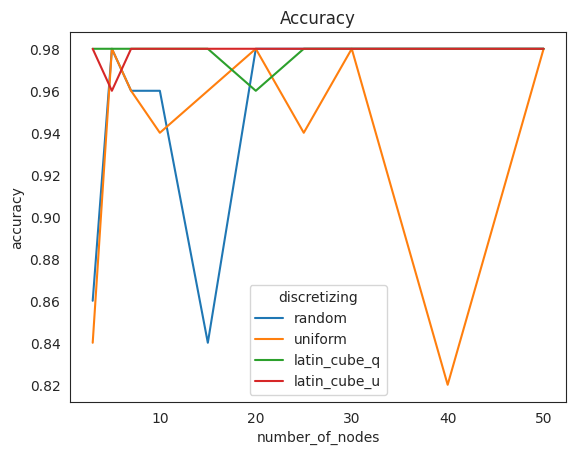

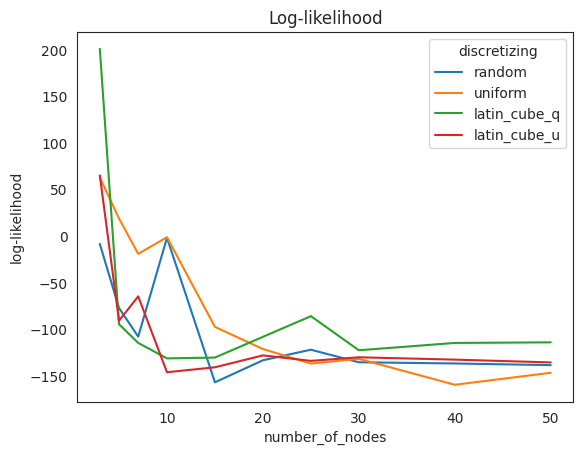

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

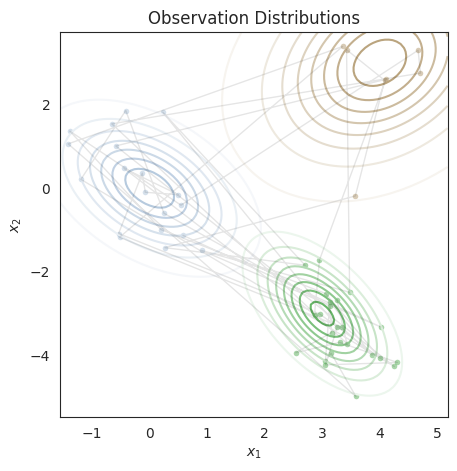

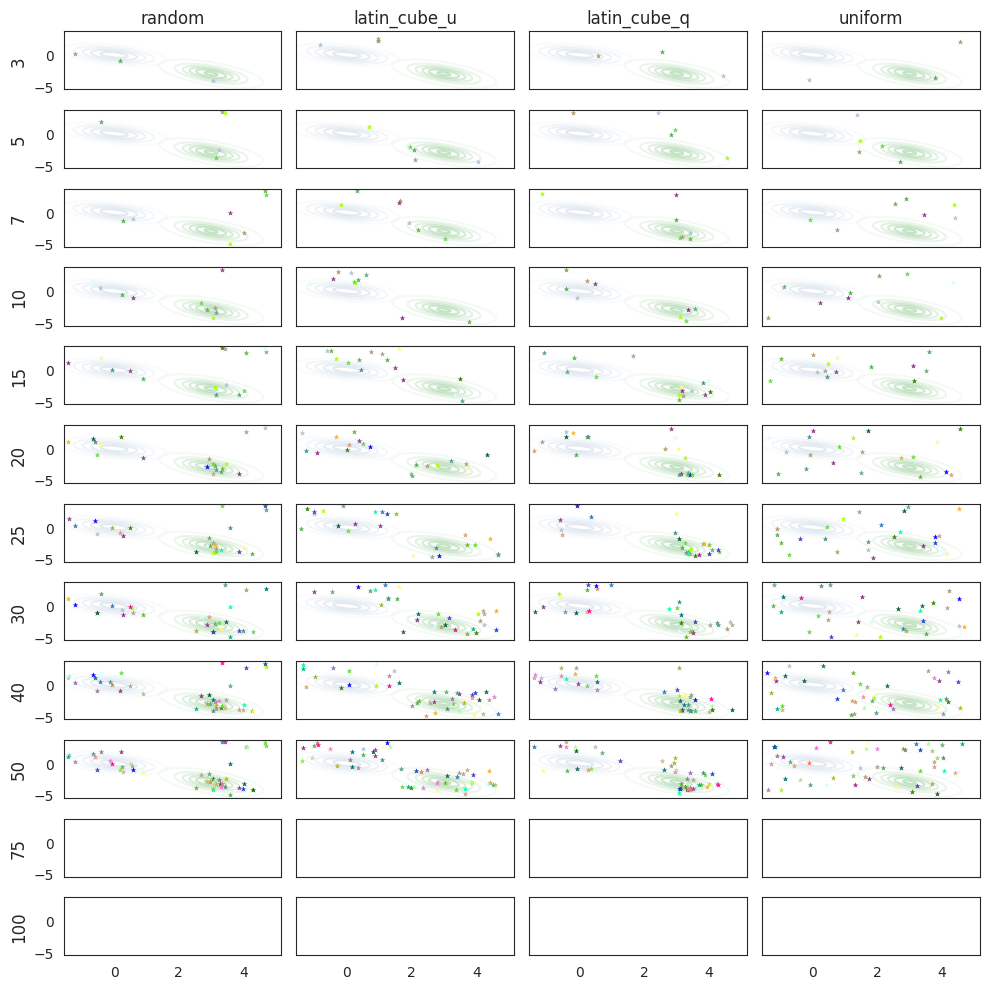

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.20      235.291465     5.131357e+173
30       uniform                3      0.94      234.462327     2.239454e+173
20  latin_cube_q                3      0.96      237.022414     2.897167e+174
40          None                3      1.00     -152.064195      3.046537e+05
10  latin_cube_u                3      0.02      248.288152     2.262671e+179
21  latin_cube_q                5      0.76      165.056424     1.612654e+143
41          None                5      1.00     -152.064195      3.046538e+05
11  latin_cube_u                5      0.62       91.271039     1.455310e+111
1         random                5      0.92       87.531981     3.460219e+109
31       uniform                5      0.70       80.474626     2.979430e+106
42          None                7      0.98     -154.214855      3.546390e+04
22  latin_cube_q                7      0.78       18.845919      5.118300e+79
2         random                7      0.98      -44.029976      2.526223e+52
12  latin_cube_u                7      0.76      -72.317883      1.309753e+40
32       uniform                7      0.68      -66.664760      3.735164e+42
23  latin_cube_q               10      0.76      -41.317299      3.806908e+53
43          None               10      0.92     -160.942689      4.245464e+01
3         random               10      0.92     -102.084468      1.547840e+27
33       uniform               10      0.66      -57.123433      5.200625e+46
13  latin_cube_u               10      0.68       32.932925      6.714826e+85
44          None               15      1.00     -152.064195      3.046537e+05
34       uniform               15      0.98       68.106479     1.266821e+101
24  latin_cube_q               15      0.74     -108.288852      3.127491e+24
4         random               15      0.98     -134.847498      9.139507e+12
14  latin_cube_u               15      0.92      -98.666123      4.723833e+28
5         random               20      0.98     -131.877077      1.782215e+14
25  latin_cube_q               20      0.80     -143.504709      1.589073e+09
35       uniform               20      0.76     -157.546601      1.267149e+03
45          None               20      1.00     -152.064195      3.046537e+05
15  latin_cube_u               20      0.70     -143.537689      1.537521e+09
36       uniform               25      0.88     -159.542916      1.721230e+02
16  latin_cube_u               25      0.00     -145.340112      2.535353e+08
46          None               25      0.92     -160.942738      4.245260e+01
26  latin_cube_q               25      0.96      -79.702699      8.128393e+36
6         random               25      0.78     -162.305621      1.086454e+01
17  latin_cube_u               30      0.80     -148.753881      8.345594e+06
27  latin_cube_q               30      0.28     -132.172820      1.325930e+14
47          None               30      1.00     -152.064194      3.046538e+05
37       uniform               30      0.98     -117.147423      4.445985e+20
7         random               30      0.74     -161.717213      1.956834e+01
18  latin_cube_u               40      0.74     -149.076277      6.045647e+06
38       uniform               40      0.96     -156.487063      3.655771e+03
28  latin_cube_q               40      0.90     -119.517484      4.155884e+19
48          None               40      1.00     -152.064195      3.046537e+05
8         random               40      1.00     -149.568855      3.694185e+06
39       uniform               50      1.00     -152.640534      1.712008e+05
19  latin_cube_u               50      0.78     -129.279977      2.392580e+15
9         random               50      1.00     -152.064195      3.046537e+05
29  latin_cube_q               50      0.00     -143.925552      1.043215e+09
49          None               50      0.92     -160.942889      4.244615e+01

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.20 &      235.291465 &     5.131357e+173 \\
30 &       uniform &                3 &      0.94 &      234.462327 &     2.239454e+173 \\
20 &  latin\_cube\_q &                3 &      0.96 &      237.022414 &     2.897167e+174 \\
40 &          None &                3 &      1.00 &     -152.064195 &      3.046537e+05 \\
10 &  latin\_cube\_u &                3 &      0.02 &      248.288152 &     2.262671e+179 \\
21 &  latin\_cube\_q &                5 &      0.76 &      165.056424 &     1.612654e+143 \\
41 &          None &                5 &      1.00 &     -152.064195 &      3.046538e+05 \\
11 &  latin\_cube\_u &                5 &      0.62 &       91.271039 &     1.455310e+111 \\
1  &        random &                5 &      0.92 &       87.531981 &     3.460219e+109 \\
31 &       uniform &                5 

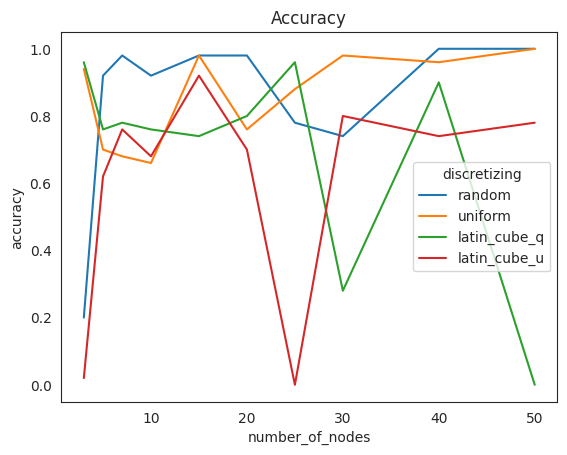

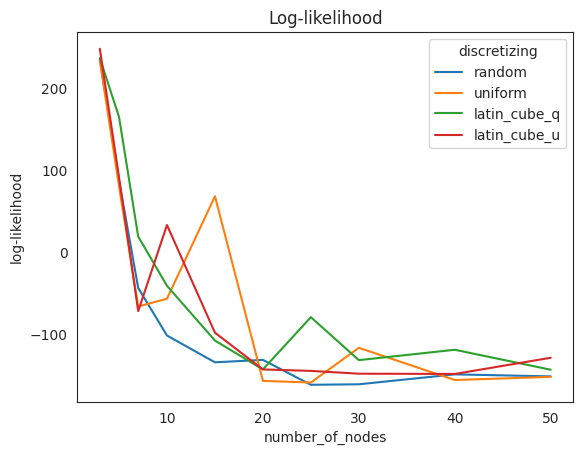

sample_size = 100


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

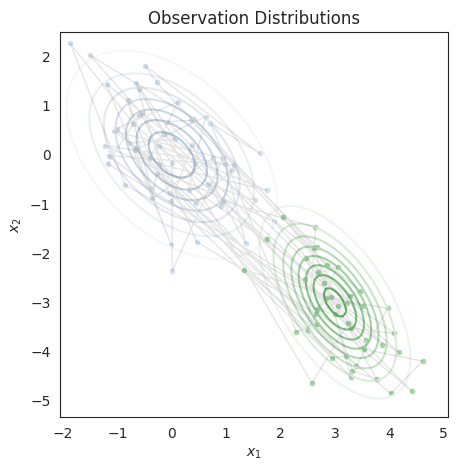

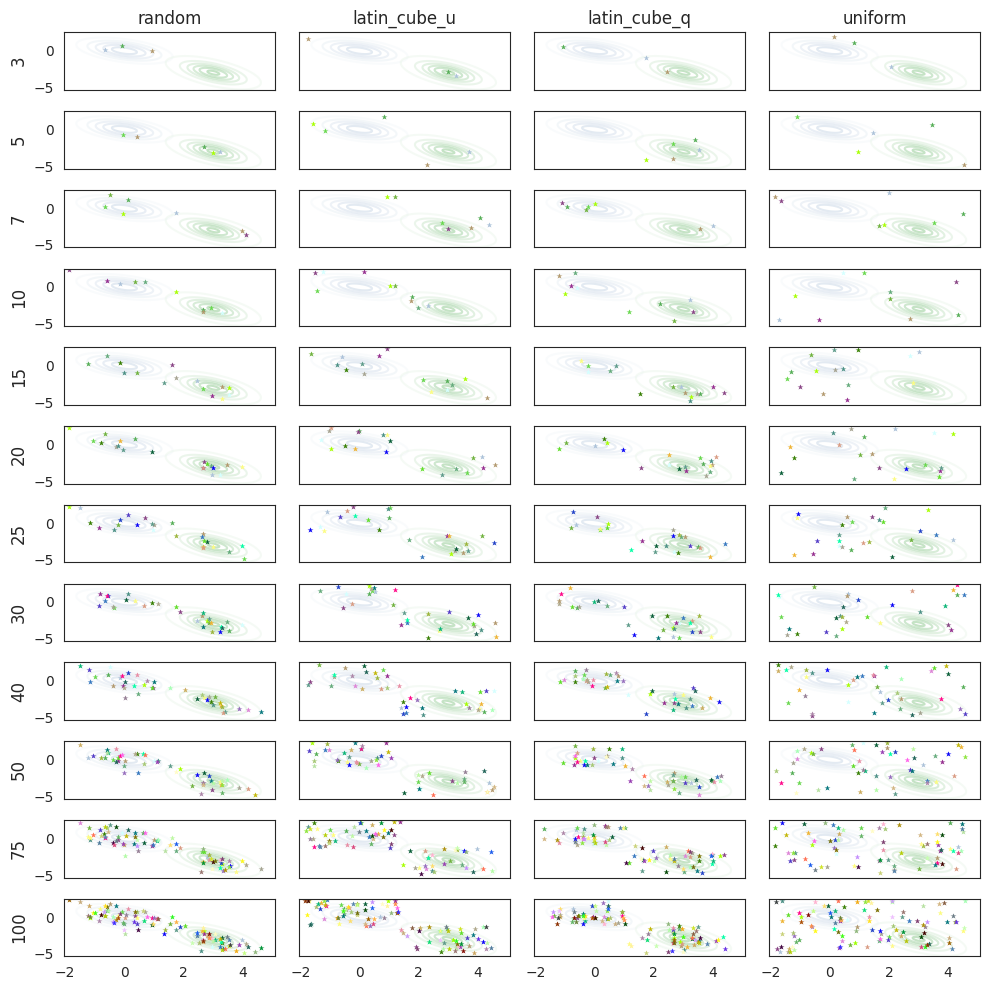

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.79      373.768063     3.613000e+287
24  latin_cube_q                3      0.80       66.060860     8.362335e+153
36       uniform                3      0.90      261.802805     8.550161e+238
12  latin_cube_u                3      0.87      255.801736     2.117108e+236
48          None                3      1.00     -305.493405      3.617102e-08
37       uniform                5      0.91     -377.303941      2.352021e-39
25  latin_cube_q                5      0.71      -57.144694     2.599175e+100
49          None                5      1.00     -305.493384      3.617178e-08
13  latin_cube_u                5      0.98     -287.540436      2.265875e+00
1         random                5      0.99       -7.345648     1.102265e+122
26  latin_cube_q                7      0.99      180.292624     3.408414e+203
2         random                7      0.93     -182.151117      1.334245e+46
14  latin_cube_u                7      0.90      112.281534     9.901737e+173
38       uniform                7      0.78     -173.527324      7.421670e+49
50          None                7      1.00     -305.493380      3.617192e-08
27  latin_cube_q               10      0.95     -202.217720      2.572888e+37
3         random               10      0.97     -214.344492      1.392613e+32
39       uniform               10      0.88     -338.066286      2.583082e-22
51          None               10      1.00     -305.493349      3.617304e-08
15  latin_cube_u               10      0.96     -196.240595      1.014502e+40
4         random               15      0.99     -292.829438      1.143541e-02
28  latin_cube_q               15      0.99     -220.890277      2.000011e+29
52          None               15      1.00     -305.493321      3.617405e-08
16  latin_cube_u               15      0.96     -281.608052      8.543534e+02
40       uniform               15      0.97       72.237260     4.024425e+156
53          None               20      1.00     -305.493338      3.617342e-08
41       uniform               20      0.97     -284.588552      4.337333e+01
29  latin_cube_q               20      0.98     -256.878086      4.695970e+13
5         random               20      0.98     -260.377770      1.418509e+12
17  latin_cube_u               20      0.98     -288.624516      7.663480e-01
30  latin_cube_q               25      0.96     -273.818113      2.064264e+06
6         random               25      0.53     -396.590292      9.896586e-48
42       uniform               25      0.98     -316.910657      3.980258e-13
54          None               25      1.00     -305.493361      3.617260e-08
18  latin_cube_u               25      0.98     -290.060143      1.823648e-01
43       uniform               30      0.98     -339.911100      4.082681e-23
7         random               30      0.99     -262.765090      1.303263e+11
19  latin_cube_u               30      0.98     -311.615500      7.935392e-11
55          None               30      1.00     -305.493554      3.616561e-08
31  latin_cube_q               30      0.97     -293.397417      6.480098e-03
8         random               40      0.98     -298.436393      4.199350e-05
56          None               40      0.53     -401.131311      1.055227e-49
32  latin_cube_q               40      0.99     -276.324490      1.683680e+05
44       uniform               40      0.99     -322.952922      9.457766e-16
20  latin_cube_u               40      0.53     -406.799708      3.644118e-52
21  latin_cube_u               50      0.98     -302.590835      6.590690e-07
33  latin_cube_q               50      0.99     -283.124338      1.875526e+02
45       uniform               50      0.99     -296.867986      2.015268e-04
57          None               50      1.00     -305.493328      3.617379e-08
9         random               50      0.99     -296.614219      2.597419e-04
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.79 &      373.768063 &     3.613000e+287 \\
24 &  latin\_cube\_q &                3 &      0.80 &       66.060860 &     8.362335e+153 \\
36 &       uniform &                3 &      0.90 &      261.802805 &     8.550161e+238 \\
12 &  latin\_cube\_u &                3 &      0.87 &      255.801736 &     2.117108e+236 \\
48 &          None &                3 &      1.00 &     -305.493405 &      3.617102e-08 \\
37 &       uniform &                5 &      0.91 &     -377.303941 &      2.352021e-39 \\
25 &  latin\_cube\_q &                5 &      0.71 &      -57.144694 &     2.599175e+100 \\
49 &          None &                5 &      1.00 &     -305.493384 &      3.617178e-08 \\
13 &  latin\_cube\_u &                5 &      0.98 &     -287.540436 &      2.265875e+00 \\
1  &        random &                5 

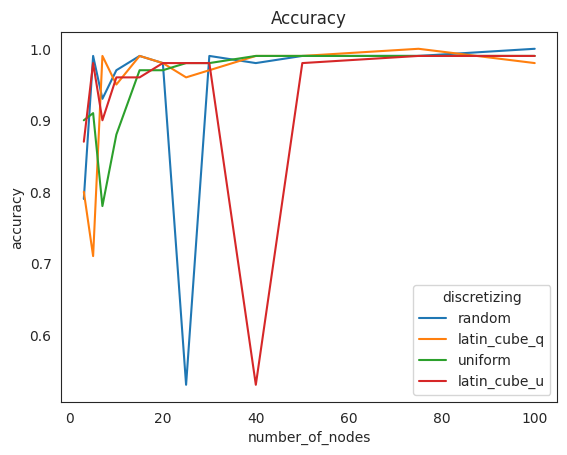

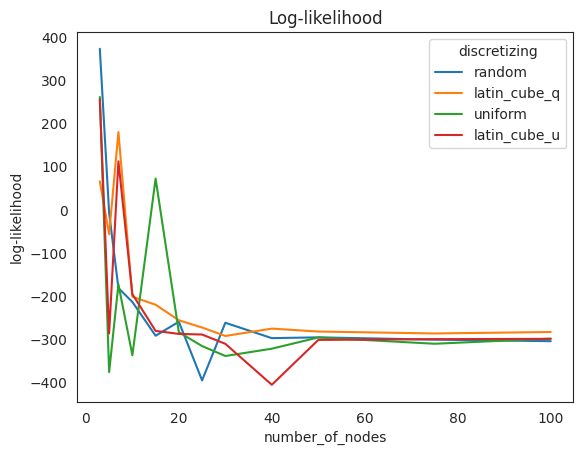

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

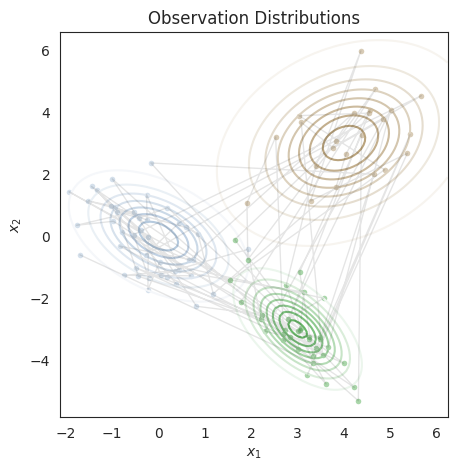

/tmp/ipykernel_17046/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


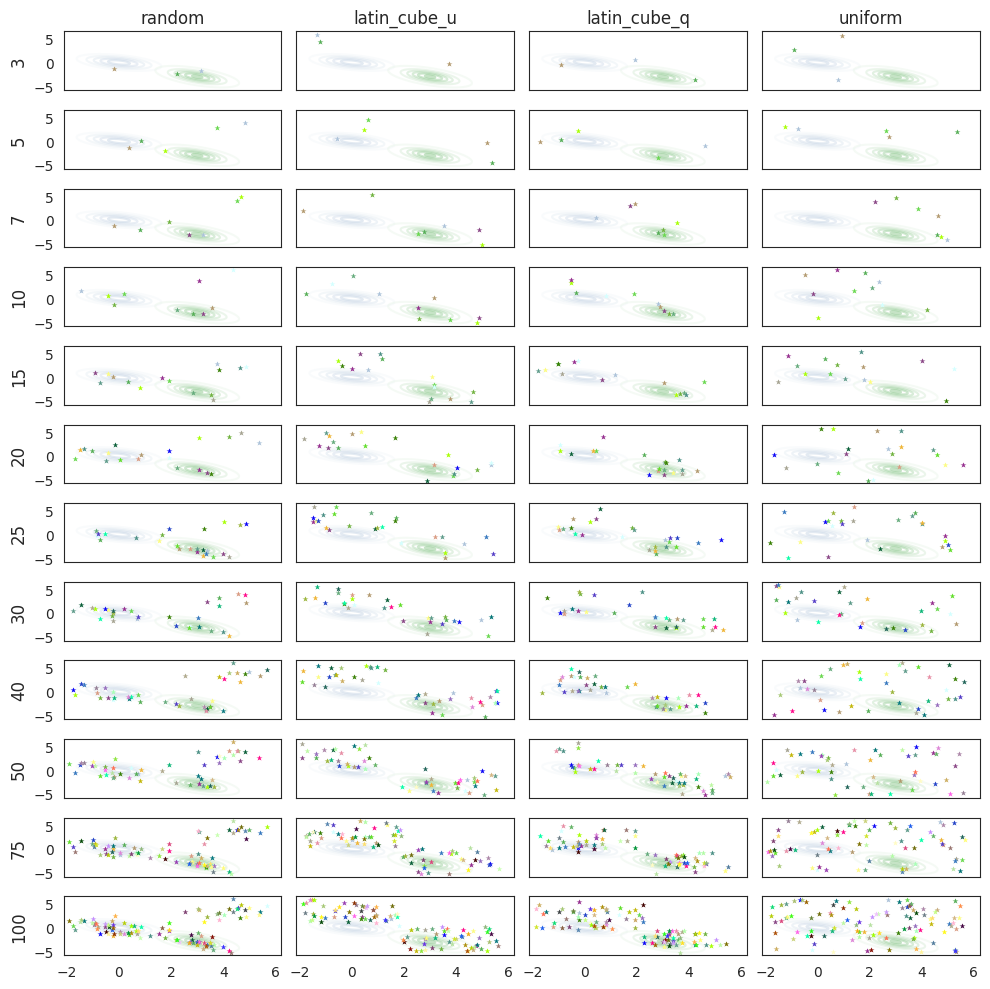

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.92      534.558101               inf
24  latin_cube_q                3      0.87      537.897849               inf
36       uniform                3      0.79      539.565568               inf
12  latin_cube_u                3      0.21      635.069818               inf
48          None                3      0.04     -371.378865      4.278704e-10
37       uniform                5      0.24      302.797125     2.643775e+283
25  latin_cube_q                5      0.15      121.379241     4.299703e+204
49          None                5      0.96     -357.290877      5.618849e-04
13  latin_cube_u                5      0.00      169.814471     4.662206e+225
1         random                5      0.96       30.898121     2.177647e+165
26  latin_cube_q                7      0.92      112.877735     8.735368e+200
2         random                7      0.92     -123.803023      1.419496e+98
14  latin_cube_u                7      0.76       16.008313     7.437479e+158
38       uniform                7      0.66     -149.521597      9.609465e+86
50          None                7      0.03     -357.290877      5.618852e-04
27  latin_cube_q               10      0.76     -162.895876      1.493907e+81
3         random               10      0.96     -274.526948      4.938163e+32
39       uniform               10      0.91       -5.503663     3.379819e+149
51          None               10      0.96     -357.290915      5.618638e-04
15  latin_cube_u               10      0.65     -311.585441      3.974350e+16
4         random               15      0.06     -291.658332      1.792668e+25
28  latin_cube_q               15      0.22     -284.991958      1.408215e+28
52          None               15      0.01     -357.290894      5.618758e-04
16  latin_cube_u               15      0.65     -230.036107      1.036793e+52
40       uniform               15      0.59     -250.355754      1.552320e+43
53          None               20      0.01     -372.035517      2.218869e-10
41       uniform               20      0.90     -178.219832      3.305326e+74
29  latin_cube_q               20      0.91     -261.180450      3.089410e+38
5         random               20      0.93     -322.157126      1.018690e+12
17  latin_cube_u               20      0.81     -144.097774      2.178892e+89
30  latin_cube_q               25      0.10     -275.998908      1.133186e+32
6         random               25      0.93     -294.120958      1.527547e+24
42       uniform               25      0.74     -296.252065      1.813289e+23
54          None               25      0.58     -385.913968      2.083518e-16
18  latin_cube_u               25      0.53     -376.607139      2.294571e-12
43       uniform               30      0.90     -347.896181      6.756351e+00
7         random               30      0.96     -339.440539      3.176515e+04
19  latin_cube_u               30      0.62     -319.526443      1.414272e+13
55          None               30      0.96     -357.290890      5.618778e-04
31  latin_cube_q               30      0.96     -284.488090      2.330753e+28
8         random               40      0.98     -339.650449      2.575066e+04
56          None               40      0.96     -357.290912      5.618657e-04
32  latin_cube_q               40      0.91     -198.886996      3.496063e+65
44       uniform               40      0.92     -350.400441      5.522376e-01
20  latin_cube_u               40      0.05     -299.843763      4.995884e+21
21  latin_cube_u               50      0.87     -309.827163      2.306092e+17
33  latin_cube_q               50      0.70     -313.209716      7.831635e+15
45       uniform               50      0.77     -363.425353      1.217527e-06
57          None               50      0.01     -357.290893      5.618764e-04
9         random               50      0.96     -330.774125      1.843855e+08
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.92 &      534.558101 &               inf \\
24 &  latin\_cube\_q &                3 &      0.87 &      537.897849 &               inf \\
36 &       uniform &                3 &      0.79 &      539.565568 &               inf \\
12 &  latin\_cube\_u &                3 &      0.21 &      635.069818 &               inf \\
48 &          None &                3 &      0.04 &     -371.378865 &      4.278704e-10 \\
37 &       uniform &                5 &      0.24 &      302.797125 &     2.643775e+283 \\
25 &  latin\_cube\_q &                5 &      0.15 &      121.379241 &     4.299703e+204 \\
49 &          None &                5 &      0.96 &     -357.290877 &      5.618849e-04 \\
13 &  latin\_cube\_u &                5 &      0.00 &      169.814471 &     4.662206e+225 \\
1  &        random &                5 

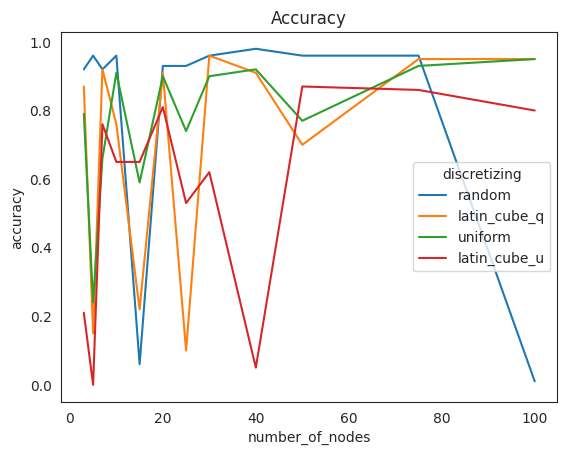

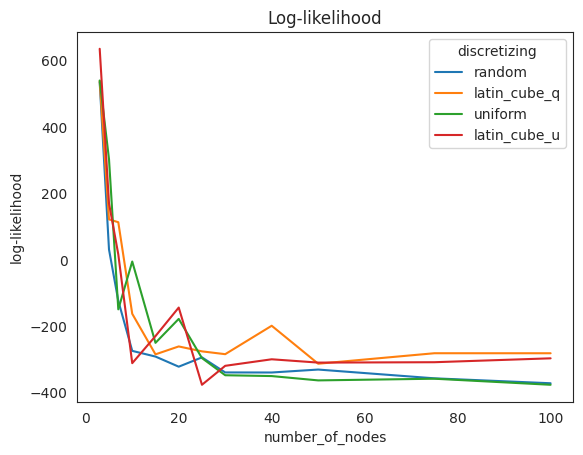

sample_size = 1000


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

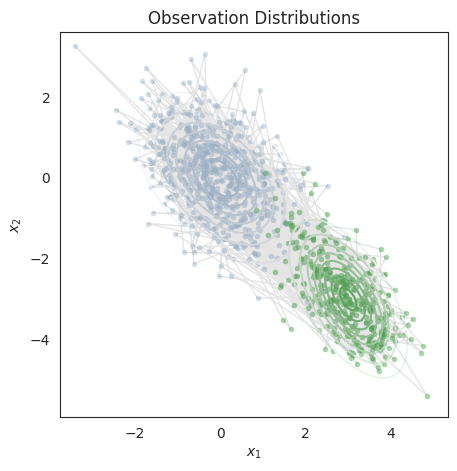

/tmp/ipykernel_17046/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


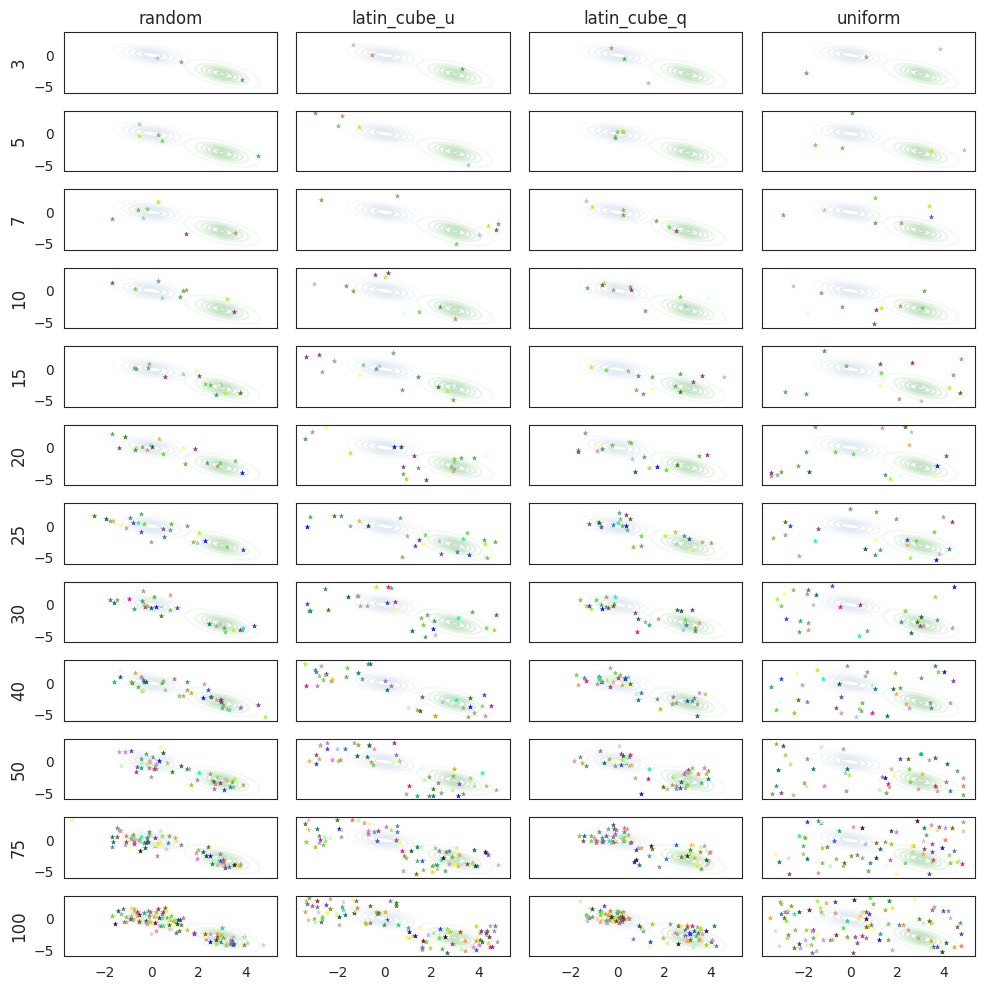

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     0.895     1197.012412               inf
24  latin_cube_q                3     0.932     1000.981869               inf
36       uniform                3     0.675     -105.974397               inf
12  latin_cube_u                3     0.972     2096.394697               inf
48          None                3     0.978    -3122.197532      2.957696e-61
37       uniform                5     0.970    -1717.736496               inf
25  latin_cube_q                5     0.562     1727.163452               inf
49          None                5     0.978    -3122.197731      2.957107e-61
13  latin_cube_u                5     0.964     2644.747395               inf
1         random                5     0.905      241.544930               inf
26  latin_cube_q                7     0.937    -2396.199514     5.859856e+254
2         random                7     0.969    -1690.380634               inf
14  latin_cube_u                7     0.936    -2434.928188     8.876409e+237
38       uniform                7     0.799    -1191.793637               inf
50          None                7     0.978    -3122.197744      2.957069e-61
27  latin_cube_q               10     0.946    -2246.606801               inf
3         random               10     0.955    -2660.042907     1.521097e+140
39       uniform               10     0.892    -2085.598019               inf
51          None               10     0.978    -3122.197169      2.958772e-61
15  latin_cube_u               10     0.914    -2806.569579      3.519103e+76
4         random               15     0.975    -2737.678038     2.921783e+106
28  latin_cube_q               15     0.881    -2575.431847     8.477614e+176
52          None               15     0.978    -3122.197042      2.959147e-61
16  latin_cube_u               15     0.870    -2866.906025      2.201135e+50
40       uniform               15     0.923    -3037.725284      1.434778e-24
53          None               20     0.978    -3122.197472      2.957873e-61
41       uniform               20     0.914    -2911.854152      6.636255e+30
29  latin_cube_q               20     0.932    -2713.082593     1.403828e+117
5         random               20     0.953    -3010.077149      1.459544e-12
17  latin_cube_u               20     0.937    -2566.968435     4.016860e+180
30  latin_cube_q               25     0.974    -2784.280268      1.684833e+86
6         random               25     0.950    -3051.405290      1.642985e-30
42       uniform               25     0.872    -3665.748630     2.568687e-297
54          None               25     0.978    -3122.197691      2.957228e-61
18  latin_cube_u               25     0.847    -3208.315950      1.175439e-98
43       uniform               30     0.511    -3639.423620     6.958534e-286
7         random               30     0.957    -2662.872066     8.983981e+138
19  latin_cube_u               30     0.954    -3105.511309      5.220211e-54
55          None               30     0.978    -3122.197166      2.958778e-61
31  latin_cube_q               30     0.863    -2892.824073      1.220622e+39
8         random               40     0.959    -3018.741792      2.518897e-16
56          None               40     0.978    -3122.197252      2.958525e-61
32  latin_cube_q               40     0.971    -2912.590978      3.176314e+30
44       uniform               40     0.912    -3066.623176      4.041941e-37
20  latin_cube_u               40     0.966    -2886.898839      4.569592e+41
21  latin_cube_u               50     0.948    -3114.473136      6.692927e-58
33  latin_cube_q               50     0.967    -3014.642341      1.519077e-14
45       uniform               50     0.885    -3597.531131     1.086913e-267
57          None               50     0.978    -3122.197192      2.958703e-61
9         random               50     0.974    -2944.852494      3.096886e+16
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     0.895 &     1197.012412 &               inf \\
24 &  latin\_cube\_q &                3 &     0.932 &     1000.981869 &               inf \\
36 &       uniform &                3 &     0.675 &     -105.974397 &               inf \\
12 &  latin\_cube\_u &                3 &     0.972 &     2096.394697 &               inf \\
48 &          None &                3 &     0.978 &    -3122.197532 &      2.957696e-61 \\
37 &       uniform &                5 &     0.970 &    -1717.736496 &               inf \\
25 &  latin\_cube\_q &                5 &     0.562 &     1727.163452 &               inf \\
49 &          None &                5 &     0.978 &    -3122.197731 &      2.957107e-61 \\
13 &  latin\_cube\_u &                5 &     0.964 &     2644.747395 &               inf \\
1  &        random &                5 

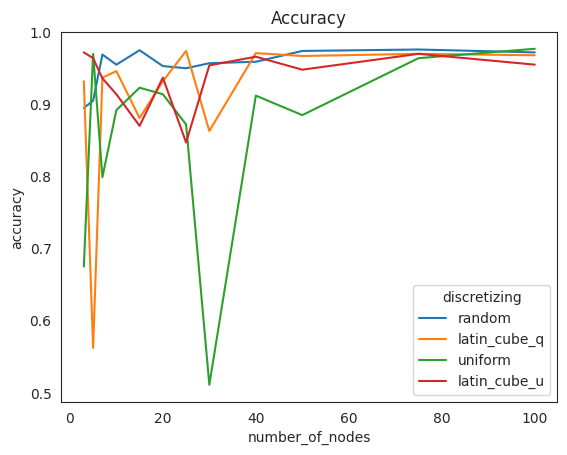

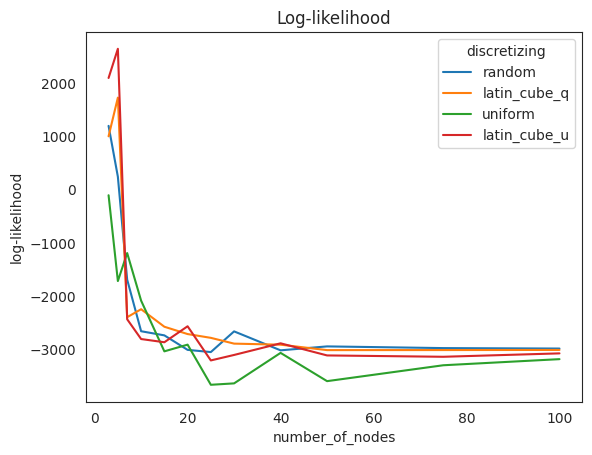

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

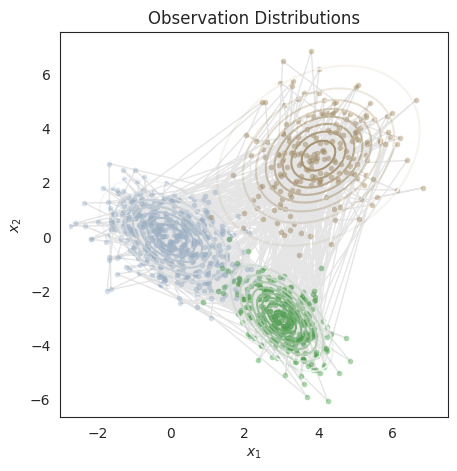

/tmp/ipykernel_17046/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


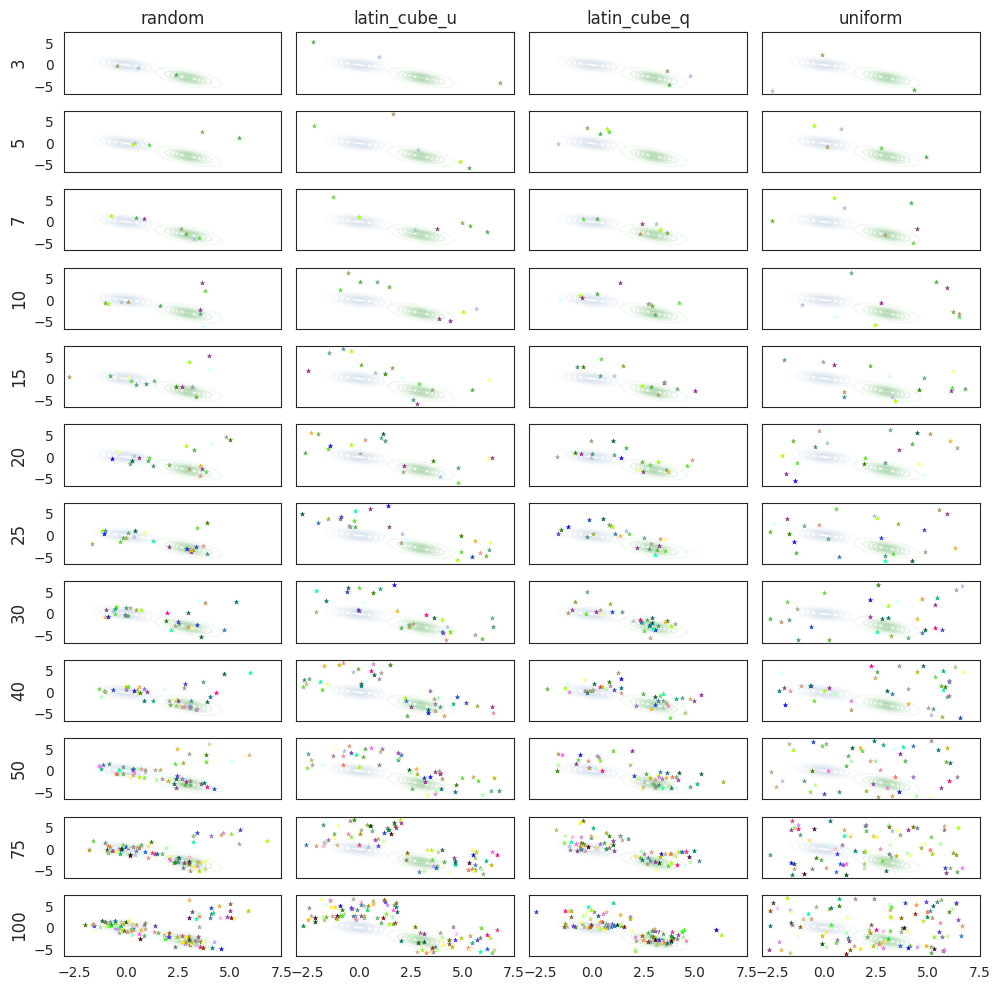

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     0.760     7528.831553               inf
24  latin_cube_q                3     0.619     8601.402532               inf
36       uniform                3     0.769     8438.913628               inf
12  latin_cube_u                3     0.733     8572.363696               inf
48          None                3     0.977    -3563.981277      2.407229e-35
37       uniform                5     0.771     -247.662236               inf
25  latin_cube_q                5     0.538     4791.697674               inf
49          None                5     0.977    -3563.981235      2.407331e-35
13  latin_cube_u                5     0.555     -655.146864               inf
1         random                5     0.009     3170.742130               inf
26  latin_cube_q                7     0.877     -306.032554               inf
2         random                7     0.629    -1485.014991               inf
14  latin_cube_u                7     0.830     5001.459919               inf
38       uniform                7     0.086     3202.590602               inf
50          None                7     0.017    -3857.037546     1.284685e-162
27  latin_cube_q               10     0.850    -2483.678435               inf
3         random               10     0.930    -1309.521791               inf
39       uniform               10     0.786    -3184.094163     2.314168e+130
51          None               10     0.977    -3563.981350      2.407055e-35
15  latin_cube_u               10     0.815      962.276330               inf
4         random               15     0.966    -3061.917734     2.660381e+183
28  latin_cube_q               15     0.060    -1742.748232               inf
52          None               15     0.977    -3563.981154      2.407526e-35
16  latin_cube_u               15     0.718    -1618.384056               inf
40       uniform               15     0.584    -3324.066879      3.758519e+69
53          None               20     0.977    -3563.981309      2.407152e-35
41       uniform               20     0.663    -3650.481896      6.527940e-73
29  latin_cube_q               20     0.915    -2996.548875     6.520465e+211
5         random               20     0.018    -3218.017331     4.283019e+115
17  latin_cube_u               20     0.741     -815.092547               inf
30  latin_cube_q               25     0.869    -3082.355154     3.540665e+174
6         random               25     0.015    -2087.951198               inf
42       uniform               25     0.209      709.701308               inf
54          None               25     0.977    -3563.981218      2.407372e-35
18  latin_cube_u               25     0.023    -2398.111660               inf
43       uniform               30     0.761    -3455.587450      2.859949e+12
7         random               30     0.894    -3038.007970     6.439061e+193
19  latin_cube_u               30     0.803    -2718.084864               inf
55          None               30     0.977    -3563.981152      2.407530e-35
31  latin_cube_q               30     0.861    -2906.210311     1.116397e+251
8         random               40     0.007    -3416.341922      3.165735e+29
56          None               40     0.977    -3563.981593      2.406469e-35
32  latin_cube_q               40     0.046    -3390.243684      6.835893e+40
44       uniform               40     0.006    -3746.607889     1.168928e-114
20  latin_cube_u               40     0.743    -3274.656991      1.080086e+91
21  latin_cube_u               50     0.838    -2686.741877               inf
33  latin_cube_q               50     0.886    -2971.594429     4.485975e+222
45       uniform               50     0.942    -3454.748237      6.619479e+12
57          None               50     0.977    -3563.981224      2.407357e-35
9         random               50     0.960    -3423.345250      2.877186e+26
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     0.760 &     7528.831553 &               inf \\
24 &  latin\_cube\_q &                3 &     0.619 &     8601.402532 &               inf \\
36 &       uniform &                3 &     0.769 &     8438.913628 &               inf \\
12 &  latin\_cube\_u &                3 &     0.733 &     8572.363696 &               inf \\
48 &          None &                3 &     0.977 &    -3563.981277 &      2.407229e-35 \\
37 &       uniform &                5 &     0.771 &     -247.662236 &               inf \\
25 &  latin\_cube\_q &                5 &     0.538 &     4791.697674 &               inf \\
49 &          None &                5 &     0.977 &    -3563.981235 &      2.407331e-35 \\
13 &  latin\_cube\_u &                5 &     0.555 &     -655.146864 &               inf \\
1  &        random &                5 

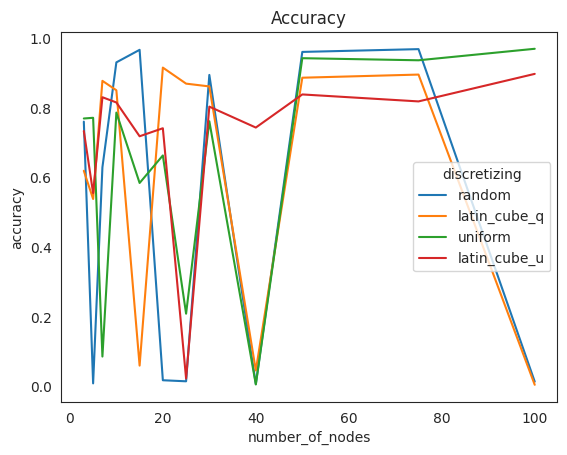

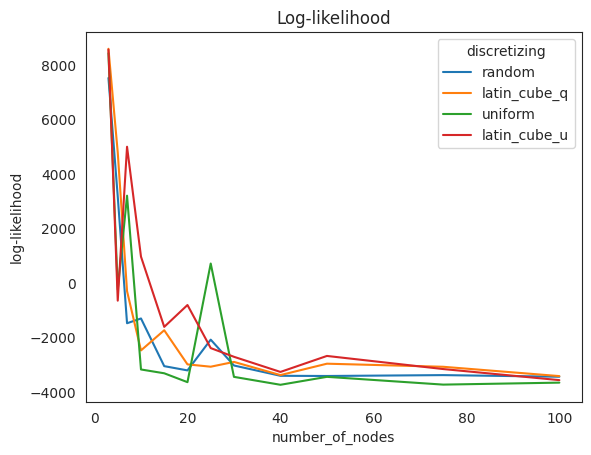

sample_size = 10000


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

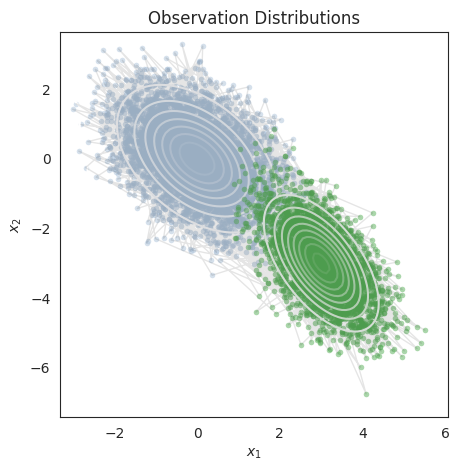

/tmp/ipykernel_17046/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


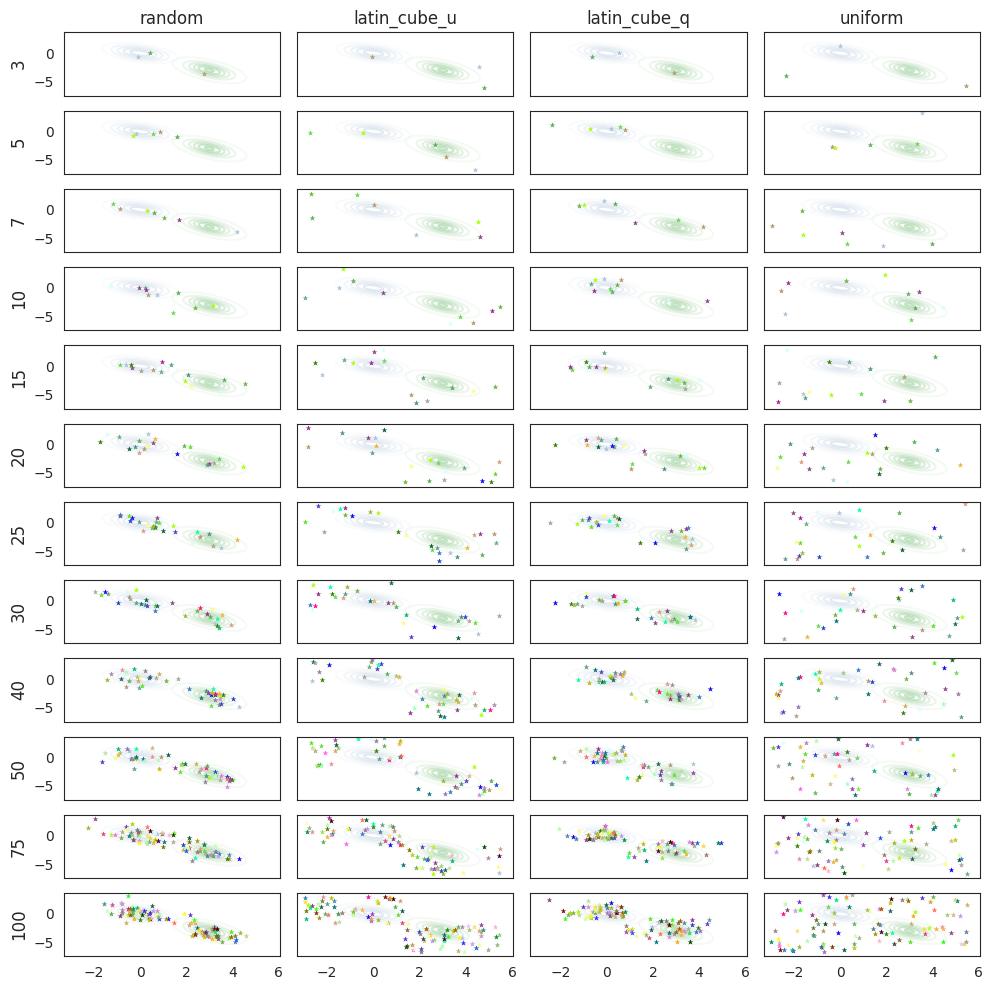

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3    0.9710    32422.117216               inf
24  latin_cube_q                3    0.9701    28776.397725               inf
36       uniform                3    0.9022    67182.224453               inf
12  latin_cube_u                3    0.9662    66161.463533               inf
48          None                3    0.9793   -31231.023987      0.000000e+00
37       uniform                5    0.9064   -14554.186820               inf
25  latin_cube_q                5    0.8000    57388.467162               inf
49          None                5    0.9793   -31231.023781      0.000000e+00
13  latin_cube_u                5    0.9545     1328.401522               inf
1         random                5    0.9357    40742.071638               inf
26  latin_cube_q                7    0.8686   -25245.428161               inf
2         random                7    0.8349    -2822.064348               inf
14  latin_cube_u                7    0.9075    34586.196178               inf
38       uniform                7    0.9549    45072.130785               inf
50          None                7    0.9793   -31231.024015      0.000000e+00
27  latin_cube_q               10    0.9723   -19522.243506               inf
3         random               10    0.9476   -20804.804963               inf
39       uniform               10    0.9110   -28623.721381               inf
51          None               10    0.9793   -31231.024013      0.000000e+00
15  latin_cube_u               10    0.8924   -29746.251142      2.989624e+90
4         random               15    0.9720   -28602.520774               inf
28  latin_cube_q               15    0.9690   -24606.518550               inf
52          None               15    0.9793   -31231.023723      0.000000e+00
16  latin_cube_u               15    0.9230   -27366.848396               inf
40       uniform               15    0.9679   -26102.902945               inf
53          None               20    0.9793   -31231.023911      0.000000e+00
41       uniform               20    0.8383   -36642.090889      0.000000e+00
29  latin_cube_q               20    0.9341   -30284.427032     5.607858e-144
5         random               20    0.9321   -29431.363472     1.696657e+227
17  latin_cube_u               20    0.9751   -27420.035298               inf
30  latin_cube_q               25    0.9643   -26541.514128               inf
6         random               25    0.9783   -28779.137671               inf
42       uniform               25    0.8489   -35193.330198      0.000000e+00
54          None               25    0.9793   -31231.023790      0.000000e+00
18  latin_cube_u               25    0.7452   -32416.657771      0.000000e+00
43       uniform               30    0.8215   -35727.656522      0.000000e+00
7         random               30    0.9761   -29365.838180     4.862577e+255
19  latin_cube_u               30    0.9611   -31669.859939      0.000000e+00
55          None               30    0.9793   -31231.023784      0.000000e+00
31  latin_cube_q               30    0.9732   -28084.667429               inf
8         random               40    0.9703   -29105.278291               inf
56          None               40    0.9793   -31231.023762      0.000000e+00
32  latin_cube_q               40    0.9427   -26991.057519               inf
44       uniform               40    0.9501   -33787.860422      0.000000e+00
20  latin_cube_u               40    0.9317   -29372.621756     5.505504e+252
21  latin_cube_u               50    0.9660   -31389.437996      0.000000e+00
33  latin_cube_q               50    0.9509   -28805.510649               inf
45       uniform               50    0.9624   -30372.109024     4.666507e-182
57          None               50    0.9793   -31231.024011      0.000000e+00
9         random               50    0.9784   -30003.106634      8.408018e-22
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &    0.9710 &    32422.117216 &               inf \\
24 &  latin\_cube\_q &                3 &    0.9701 &    28776.397725 &               inf \\
36 &       uniform &                3 &    0.9022 &    67182.224453 &               inf \\
12 &  latin\_cube\_u &                3 &    0.9662 &    66161.463533 &               inf \\
48 &          None &                3 &    0.9793 &   -31231.023987 &      0.000000e+00 \\
37 &       uniform &                5 &    0.9064 &   -14554.186820 &               inf \\
25 &  latin\_cube\_q &                5 &    0.8000 &    57388.467162 &               inf \\
49 &          None &                5 &    0.9793 &   -31231.023781 &      0.000000e+00 \\
13 &  latin\_cube\_u &                5 &    0.9545 &     1328.401522 &               inf \\
1  &        random &                5 

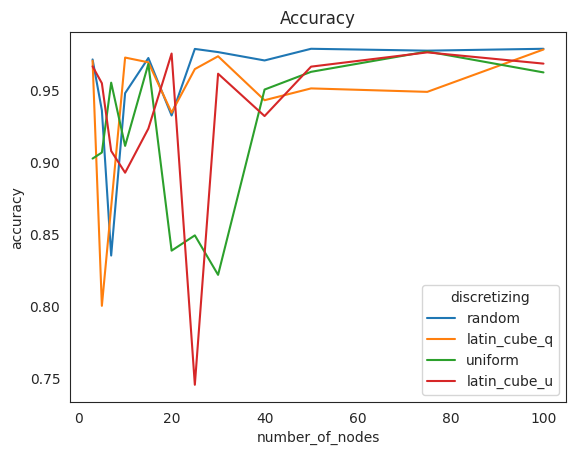

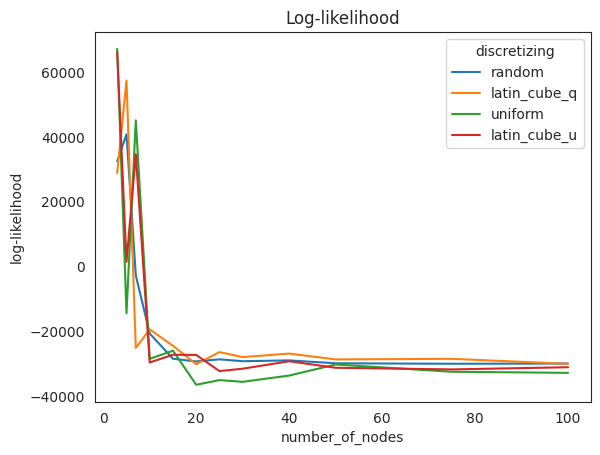

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

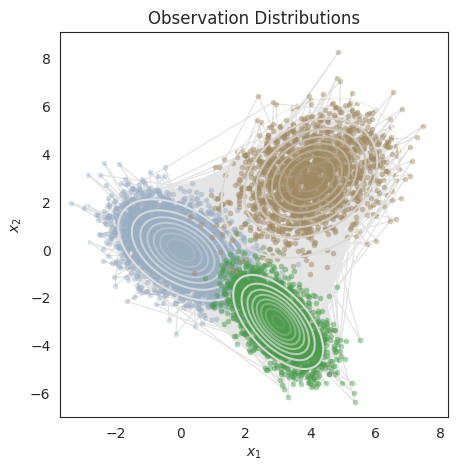

/tmp/ipykernel_17046/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


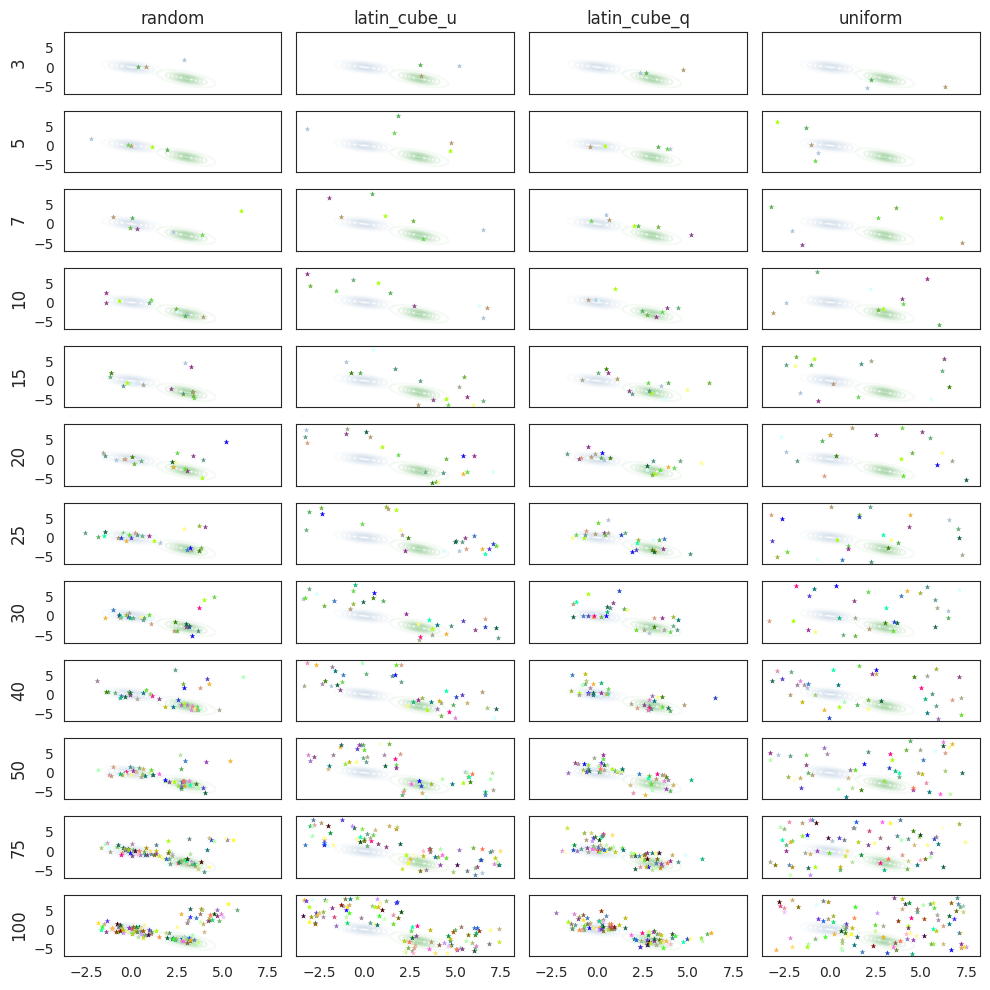

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3    0.8871    99489.642094               inf
24  latin_cube_q                3    0.0371   100646.118197               inf
36       uniform                3    0.5110   117509.538290               inf
12  latin_cube_u                3    0.7955   102302.358067               inf
48          None                3    0.0119   -35838.892644               0.0
37       uniform                5    0.7009    32112.256242               inf
25  latin_cube_q                5    0.9423    24972.352666               inf
49          None                5    0.0119   -35838.892862               0.0
13  latin_cube_u                5    0.7025    49655.454540               inf
1         random                5    0.6399    -4578.162261               inf
26  latin_cube_q                7    0.6118    -1898.931631               inf
2         random                7    0.0499   -30691.822217               inf
14  latin_cube_u                7    0.7833    13880.957818               inf
38       uniform                7    0.6375   -16581.729612               inf
50          None                7    0.9777   -35838.892394               0.0
27  latin_cube_q               10    0.9066     6829.153473               inf
3         random               10    0.7006   -22794.620140               inf
39       uniform               10    0.1792    25927.266339               inf
51          None               10    0.0104   -35838.892584               0.0
15  latin_cube_u               10    0.5428    37279.516339               inf
4         random               15    0.9711   -27600.009135               inf
28  latin_cube_q               15    0.7136   -30951.777766               inf
52          None               15    0.9777   -35838.892555               0.0
16  latin_cube_u               15    0.6547   -27028.500360               inf
40       uniform               15    0.8558    57579.045081               inf
53          None               20    0.9777   -35838.892785               0.0
41       uniform               20    0.9501   -30517.445873               inf
29  latin_cube_q               20    0.0908   -20465.404112               inf
5         random               20    0.0962   -22763.003580               inf
17  latin_cube_u               20    0.8263    60433.205261               inf
30  latin_cube_q               25    0.7987   -27124.617894               inf
6         random               25    0.9428   -26631.497082               inf
42       uniform               25    0.8576    48612.197083               inf
54          None               25    0.0104   -35838.892175               0.0
18  latin_cube_u               25    0.4914   -28853.951807               inf
43       uniform               30    0.0238     7806.777344               inf
7         random               30    0.9717   -30985.640248               inf
19  latin_cube_u               30    0.1995      -40.718439               inf
55          None               30    0.9777   -35838.893431               0.0
31  latin_cube_q               30    0.8715   -30407.903183               inf
8         random               40    0.9741   -33398.384397               inf
56          None               40    0.9777   -35838.892585               0.0
32  latin_cube_q               40    0.1206   -30449.730364               inf
44       uniform               40    0.7274    -8515.827587               inf
20  latin_cube_u               40    0.8518    10406.603911               inf
21  latin_cube_u               50    0.8265   -30253.900629               inf
33  latin_cube_q               50    0.8053   -31204.150260               inf
45       uniform               50    0.9633   -39223.272147               0.0
57          None               50    0.9777   -35838.893360               0.0
9         random               50    0.9690   -33751.727769               inf
22  latin_cube_u          

/tmp/ipykernel_17046/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &    0.8871 &    99489.642094 &               inf \\
24 &  latin\_cube\_q &                3 &    0.0371 &   100646.118197 &               inf \\
36 &       uniform &                3 &    0.5110 &   117509.538290 &               inf \\
12 &  latin\_cube\_u &                3 &    0.7955 &   102302.358067 &               inf \\
48 &          None &                3 &    0.0119 &   -35838.892644 &               0.0 \\
37 &       uniform &                5 &    0.7009 &    32112.256242 &               inf \\
25 &  latin\_cube\_q &                5 &    0.9423 &    24972.352666 &               inf \\
49 &          None &                5 &    0.0119 &   -35838.892862 &               0.0 \\
13 &  latin\_cube\_u &                5 &    0.7025 &    49655.454540 &               inf \\
1  &        random &                5 

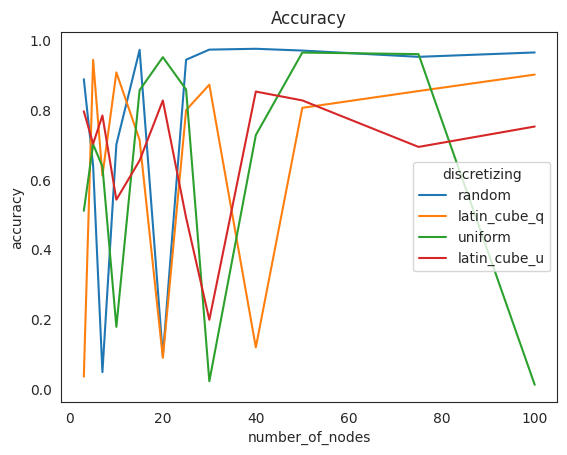

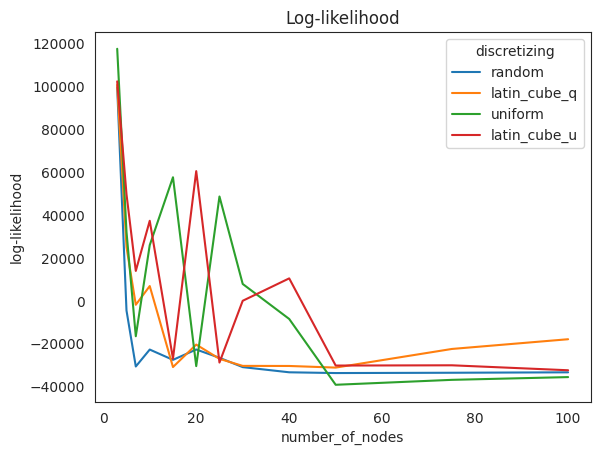

In [9]:
for sample_size in sample_sizes:
    print(f"sample_size = {sample_size}")
    evaluation(sample_size, 2)
    evaluation(sample_size, 3)

In [10]:
nodes_numbers = [5, 10, 50]
sample_sizes = [200, 5000]

def evaluation_numeric(sample_size, n_components, results):
    true_model = true_model2 if n_components == 2 else true_model3
    X, Z = true_model.sample(sample_size)

    for discretizing, number_of_nodes in itertools.product([*DISCRETIZATION_TECHNIQUES, None], nodes_numbers):
        if number_of_nodes > sample_size:
            continue
        myHMM, ll, acc = eval_model(n_components, number_of_nodes, discretizing, X, Z)
        results.append({'ll': ll, 'acc': acc, 'number_of_nodes': number_of_nodes,  'discretizing': discretizing, 'sample_size': sample_size, 'used_disc': myHMM.n_features})

    print("iter done")

results = []


In [11]:
%%time
[evaluation_numeric(sample_size, n_components, results) for sample_size, n_components in itertools.product([10000], [2]) for _ in range(50)]

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done
CPU times: user 56min 12s, sys: 27min 47s, total: 1h 23min 59s
Wall time: 13min 10s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

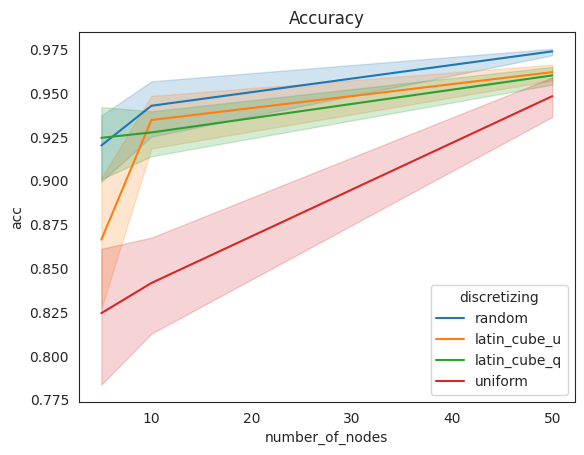

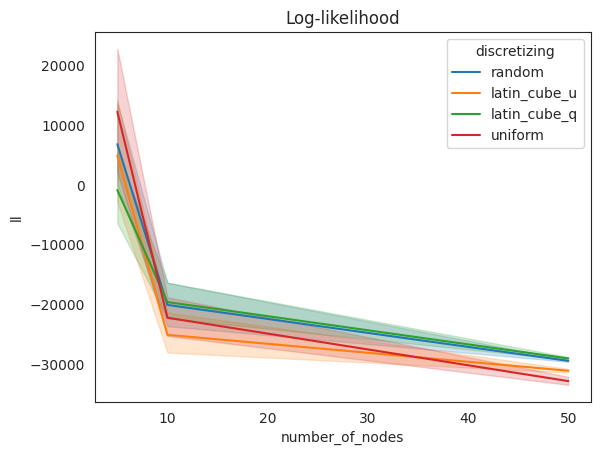

Empty DataFrame
Columns: []
Index: []

In [12]:
res = pd.DataFrame(results)
res.to_csv('results2.csv')

def plot_res(x):
    sns.lineplot(data=x, x='number_of_nodes', y='acc', hue='discretizing')
    plt.title("Accuracy")
    plt.show()
    sns.lineplot(data=res, x='number_of_nodes', y='ll', hue='discretizing')
    plt.title("Log-likelihood")
    plt.show()

res.groupby(['sample_size']).apply(plot_res)

In [13]:
results = []
[evaluation_numeric(sample_size, n_components, results) for sample_size, n_components in itertools.product([10000], [3]) for _ in range(50)]

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recognized 2 instead of 3 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

iter done


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

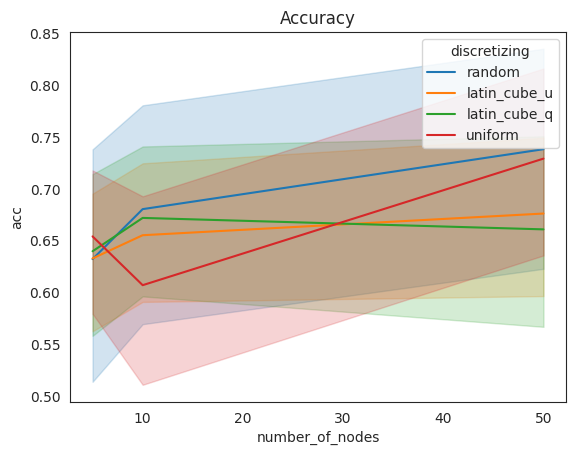

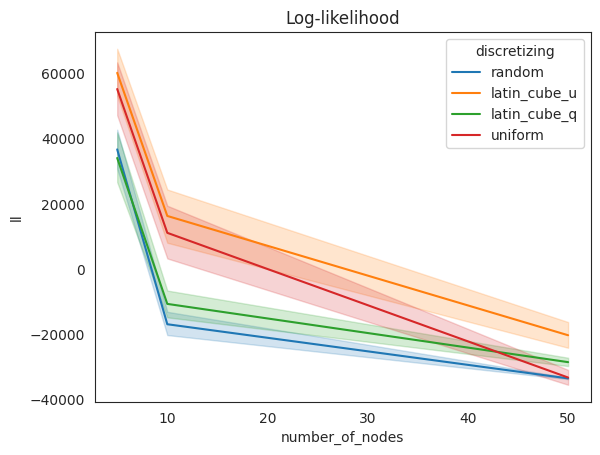

Empty DataFrame
Columns: []
Index: []

In [14]:
res = pd.DataFrame(results)
res.to_csv('results3.csv')

def plot_res(x):
    sns.lineplot(data=x, x='number_of_nodes', y='acc', hue='discretizing')
    plt.title("Accuracy")
    plt.show()
    sns.lineplot(data=res, x='number_of_nodes', y='ll', hue='discretizing')
    plt.title("Log-likelihood")
    plt.show()

res.groupby(['sample_size']).apply(plot_res)


In [15]:
import pandas as pd

res3 = pd.read_csv('results3.csv')

In [16]:
res3

Unnamed: 0            ll     acc  number_of_nodes  discretizing  \
0             0  52507.540654  0.9616                5        random   
1             1 -36034.598230  0.8285               10        random   
2             2 -32106.615621  0.0187               50        random   
3             3  85804.223402  0.6845                5  latin_cube_u   
4             4 -22005.447609  0.7754               10  latin_cube_u   
..          ...           ...     ...              ...           ...   
745         745 -16635.426355  0.7961               10       uniform   
746         746 -35705.038594  0.9132               50       uniform   
747         747 -35910.316943  0.9779                5           NaN   
748         748 -35910.316198  0.9780               10           NaN   
749         749 -35910.316677  0.0090               50           NaN   

     sample_size  used_disc  
0          10000          2  
1          10000          2  
2          10000          2  
3          10000          2  
4          10000          2  
..           ...        ...  
745        10000          2  
746        10000          2  
747        10000          2  
748        10000          2  
749        10000          2  

[750 rows x 7 columns]